This file will allow us to run over a directory and output many things. We made the functions for the following at the bottom: (A) plot the spectrograph of wav files with or without talking remove/cleaning, (B) an array or plots of the mfcc's, or (C) an array or plots of the dct's of cleaned/restricted data. In B and C the outputs will include the first up to 10 seconds of the insect noise without the talking at the beggining.

How to use this file:

First runall to load the relavent functions. The functions to call for A,B or C are in line 7. Line 8 is where we should put the relevant directory and line 9 and on is where we can run functions/experiment

In [221]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import math

In [222]:
def remove_Talking(f):
    chirp_song, sr = librosa.load(f)
    split=librosa.effects.split(chirp_song, top_db=60)
    chirp_song_split=chirp_song[split[1,0]:split[1,1]]
    if chirp_song_split.shape[0] > 220500:
        chirp_song_split = chirp_song_split[:220500]
    return chirp_song_split

In [223]:
def remove_low_freq(song):
    D = np.abs(librosa.stft(song, n_fft=n_fft,  hop_length=hop_length))
    #FIND OUT HOW MANY FREQUENCIES WE REMOVED HERE!
    D=D[64:]
    return D

def zero_low_freq(song):
    D = np.abs(librosa.stft(song, n_fft=n_fft,  hop_length=hop_length))
    D[:65]=0
    return D

In [224]:
def clean_DB(DB):
    DBclean = np.zeros(DB.shape)
    for x in range(0,DB.shape[0]):
        med = np.median(DB[x, :])
        DBclean[x, :] = DB[x, :]-med
    return DBclean

#this function is no longer used
def filt(ar,n):
    #ar is an array/list, n is the number of coefficients to contract to via partition of unity
    time = ar.shape[1]
    filt = np.zeros((n,time), dtype=float, order='C')
    length = ar.shape[0]
    for i in range(0,length):
        lower = int((n)*i/length)
        round_err = ((n)*i)%length
        filt[lower,:] = filt[lower,:] + ((length)-round_err)/(length)*ar[i,:]
        if lower < n-1:
            filt[lower + 1,:] = filt[lower + 1,:] + (round_err)/(length)*ar[i,:]
        else:
            filt[0] = filt[0]+ (round_err)/(length)*ar[i,:]
    return filt 

In [240]:
def mfcc(song,n=20):
    return librosa.feature.mfcc(y=song,n_mfcc=n)

def vert_dct_from_clean(DB, n=10, clean = True):
    if clean:
        DB = clean_DB(DB)
    time = DB.shape[1]
    ans=np.zeros((n,time), dtype=float, order='C')
    for x in range(0,time):
        col = DB[:,x]
        ans[:,x] = (scipy.fft.dct(col)[0:n])
    return ans

def tot_dct_from_clean(DB, n=10, m=10, clean = True):
    vertdct = vert_dct_from_clean(DB, n=n, clean=clean)
    ans=np.zeros((n,m), dtype=float, order='C')
    for x in range(0,n):
        row = DB[x,:]
        ans[x,:] = (scipy.fft.dct(row)[0:m])
    return ans
    

def vert_idct(dct, m = 1024-64):
    time = dct.shape[1]
    ans=np.zeros((m,time), dtype=float, order='C')
    for x in range(0,time):
        col = dct[:,x]
        ans[:,x] = (scipy.fft.idct(col,n=m))
    return ans

def tot_idct(dct, m=1024-64, time = 22050):
    n = dct.shape[0]
    vert_dct = np.zeros((n,time), dtype=float, order='C')
    for x in range(0,n):
        row = dct[x,:]
        vert_dct[x,:] = (scipy.fft.idct(row,n=time))
    return vert_idct(vert_dct,m)

#this function is no longer used
def vert_idct_old(dct,m = 1024-64):
    time = dct.shape[1]
    n = dct.shape[0]
    ans=np.zeros((m,time), dtype=float, order='C')
    coef = np.zeros((n,m,time), dtype=float, order='C')
    coef[0,:,:] = 1
    for i in range(1,n):
        for j in range(0,m):
            coef[i,j,:] = 2*math.cos((math.pi*i/(2*n))*(2*j*(n/m)+1))
    for j in range(0,m):
        tot = np.zeros(time, dtype=float, order='C')
        for i in range(0,n):
            tot = tot + coef[i,j,:]*dct[i,:]
        ans[j,:] = tot/(2*m)
    return ans

In [228]:
def plot_song(song):
    hop_length = 1024
    n_fft = 2048
    D = np.abs(librosa.stft(song, n_fft=n_fft,  hop_length=hop_length))
    DB = librosa.amplitude_to_db(D, ref=np.max)
    librosa.display.specshow(DB, hop_length=hop_length, x_axis='time', y_axis='log');
    plt.colorbar(format='%+2.0f dB');
    plt.show()
    return None

def plot_array(DB):
    librosa.display.specshow(DB, y_axis='linear', x_axis='time')
    plt.show()
    return None

def plot_no_low(D,clean = True):
    hop_length = 1024
    n_fft = 2048
    DB = librosa.amplitude_to_db(D, ref=np.max)
    if clean:
        DB = clean_DB(DB)
    librosa.display.specshow(DB, hop_length=hop_length, x_axis='time', y_axis='log');
    #NOTE THIS 750 is just a guess: Have not computed what frequencies we actually removed
    plt.ylim(750,10000)
    plt.colorbar(format='%+2.0f dB');
    plt.show()
    return None

def plot_basic(D):
    hop_length = 1024
    n_fft = 2048
    DB = librosa.amplitude_to_db(D, ref=np.max)
    librosa.display.specshow(DB, hop_length=hop_length, x_axis='time', y_axis='log');
    plt.colorbar(format='%+2.0f dB');
    plt.show()
    return None

def plot_DB_no_low(DB, clean = True):
    hop_length = 1024
    n_fft = 2048
    if clean:
        DB = clean_DB(DB)
    librosa.display.specshow(DB, hop_length=hop_length, x_axis='time', y_axis='log');
    #NOTE THIS 750 is just a guess: Have not computed what frequencies we actually removed
    plt.ylim(750,10000)
    plt.colorbar(format='%+2.0f dB');
    plt.show()
    return None

In [242]:
def get_plot(directory, no_talk = True, remove_low = True, cleaned = True, print_filename = False):
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            if print_filename:
                print (filename)
            if no_talk:
                if remove_low:
                    D = remove_low_freq(remove_Talking(f))
                    plot_no_low(D,clean = cleaned)
                else:
                    song = remove_Talking(f)
                    plot_song(song)
            else:
                song, sr = librosa.load(f)
                plot_song(song)
    return None

def get_mfcc(directory, n=20, plot = 2, print_filename=False):
    ar = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            if print_filename:
                print (filename)
            song = remove_Talking(f)
            out = mfcc(song,n=n)
            if plot != 0:
                if plot == 1:
                    plot_array(out)
                else:
                    song=librosa.feature.inverse.mfcc_to_audio(out)
                    #print (D.shape)       
                    plot_song(song)
            else:
                ar.append(out) 
    return ar
            

#currently does linear dct, could try doing log before dct
def get_dct(directory, n=10, cleaned = True, plot = 2, print_filename = False):
    ar = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            if print_filename:
                print (filename)
            D = remove_low_freq(remove_Talking(f))
            DB = librosa.amplitude_to_db(D, ref=np.max)
            out = vert_dct_from_clean(DB, n=n, clean = cleaned)
            if plot != 0:
                if plot == 1:
                    plot_array(out)
                else:
                    DB2 = vert_idct(out)
                    plot_DB_no_low(DB2,clean = False)
            else:
                ar.append(out)
    return ar

def get_total_dct(directory, n=10, m=10, cleaned = True, plot = 2, print_filename = False):
#n is the vertical number of boxes in the dct and m is the number of horizontal ones.
    ar = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            if print_filename:
                print (filename)
            D = remove_low_freq(remove_Talking(f))
            time = D.shape[1]
            DB = librosa.amplitude_to_db(D, ref=np.max)
            out = tot_dct_from_clean(DB, n=n, m=m, clean = cleaned)
            if plot != 0:
                if plot == 1:
                    plot_array(out)
                else:
                    DB2 = tot_idct(out, time= time)
                    plot_DB_no_low(DB2,clean = False)
            else:
                ar.append(out)
    return ar   

How to use continued: 

Here you will need to put the correct directory for your files. Also you can change the hop_length and n_fft constants if you like (standard is 1024, 2048 respectively)

In [230]:
directory = 'Small_audio_sample'
hop_length = 1024
n_fft = 2048

Here you will call the function you want:

For plotting call: get_plot(directory, no_talk (defaults to true i.e. removing talking at the beg), remove_low (defaults to true i.e. removes low frequencies), cleaned (defaults to true, i.e. cleans data slightly (subtracts median)))

For getting the mfcc: get_mfcc(directory, plot = False (if true plots all the stuff, if false returns an array))

For getting the dct of the cleaned data: get_dct(directory, n (defaults to 10 i.e. for each time window we get 10 numbers which describe the frequencies amplitudes at the time), cleaned = True, plot = False (if true plots all the stuff, if false returns an array))

Each one has a print_filename which if True will print the filename before you graph something (so you can go back and listen to what you are graphing.

Feel free to call the functions above in some other way to get other data

122219.wav


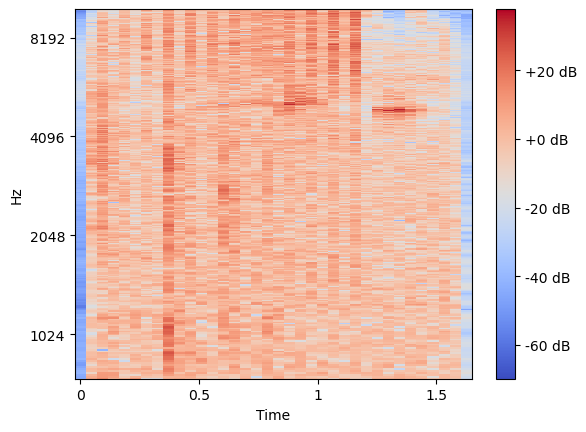

119884.wav


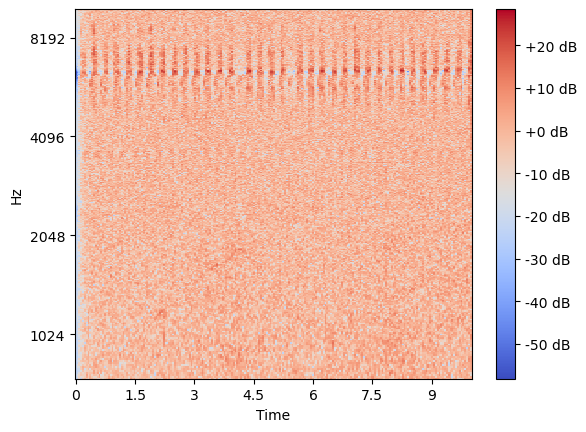

122147.wav


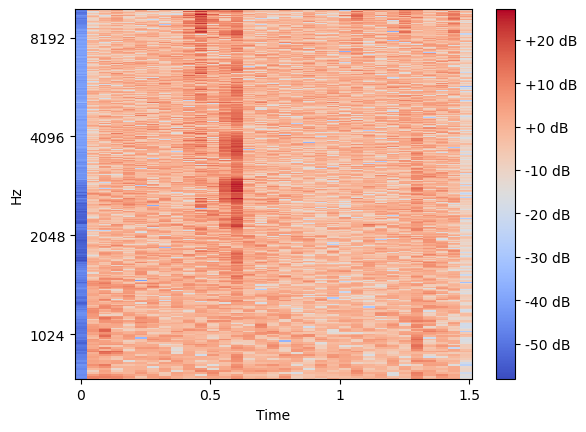

122218.wav


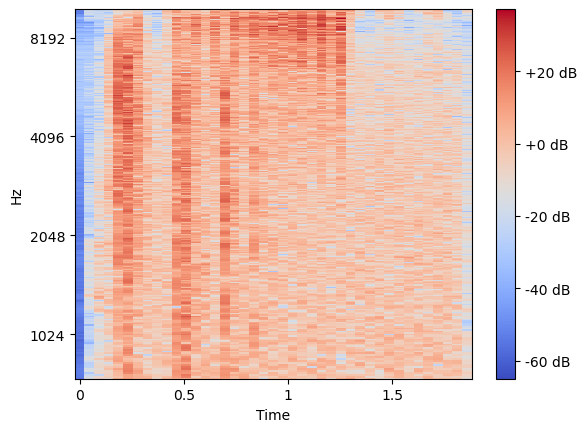

118960_mole.wav


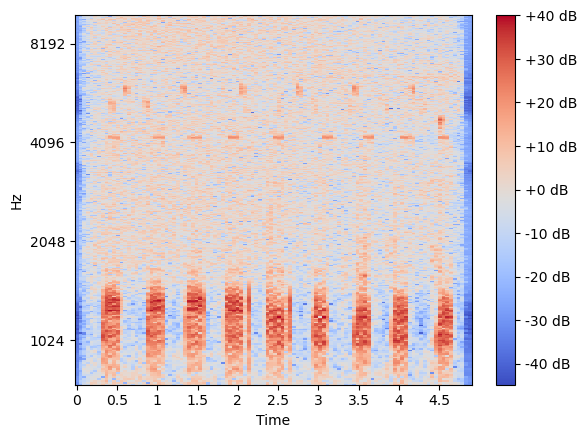

122140.wav


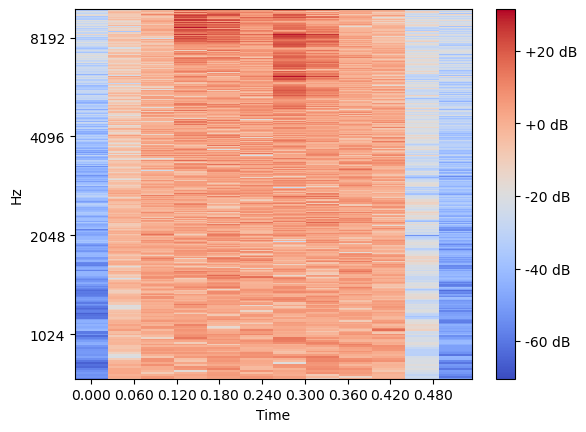

122340.wav


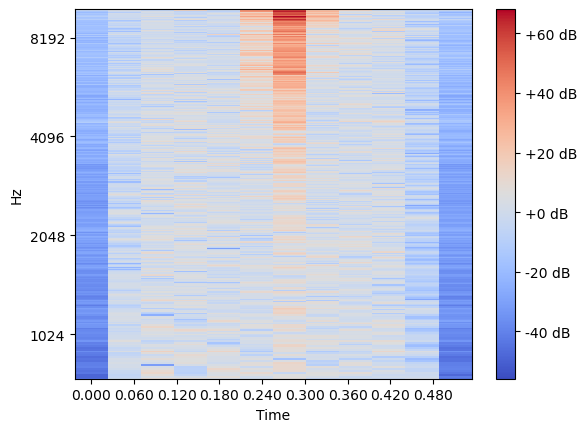

126899.wav


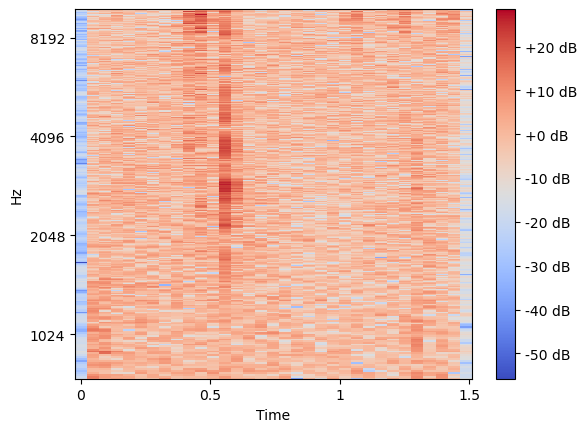

122221.wav


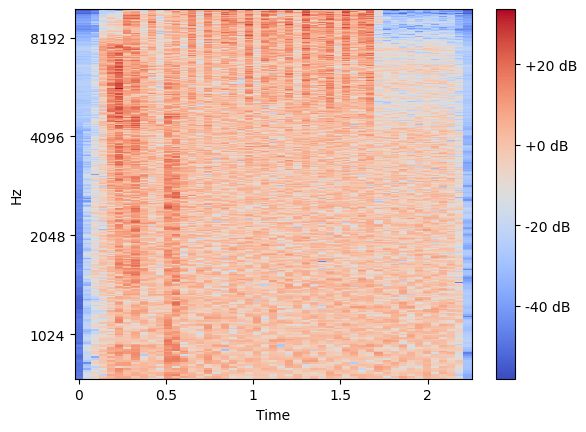

122246.wav


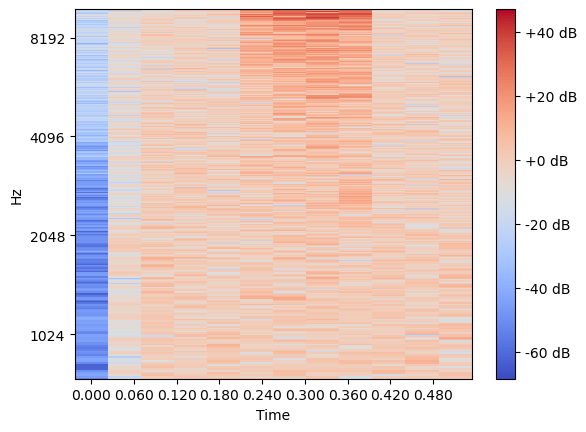

122247.wav


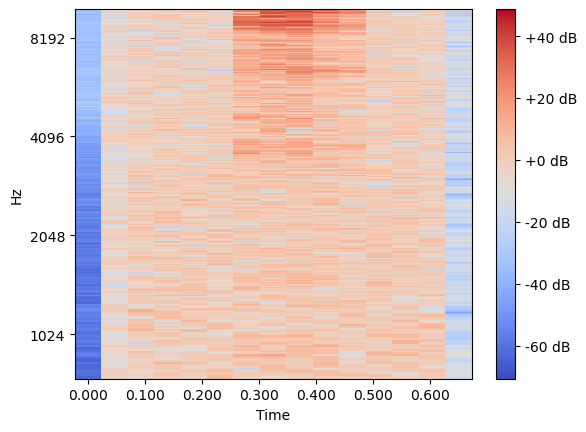

122245.wav


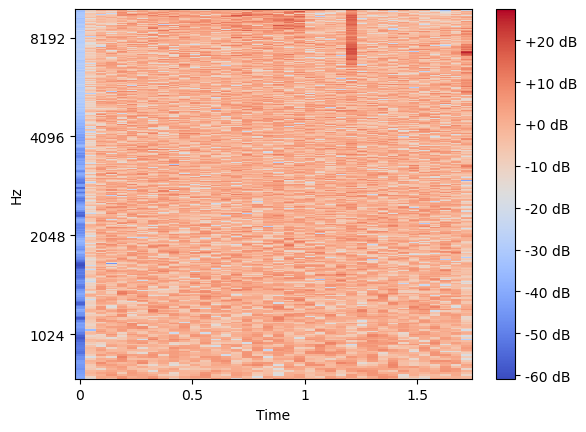

122278.wav


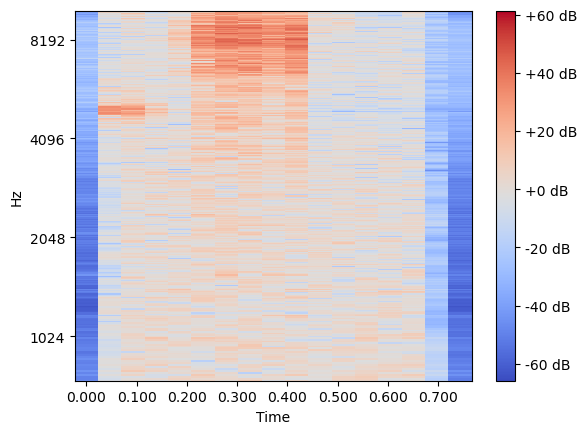

122283.wav


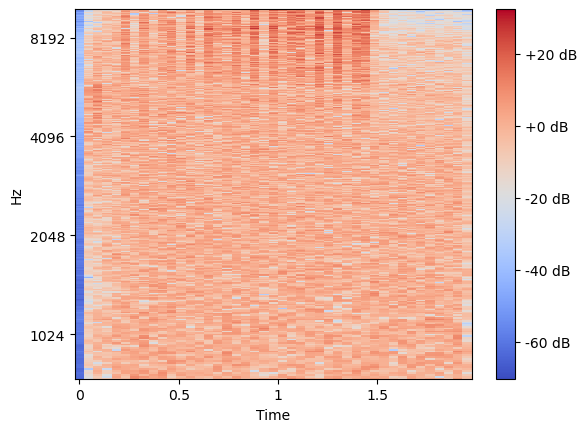

122269.wav


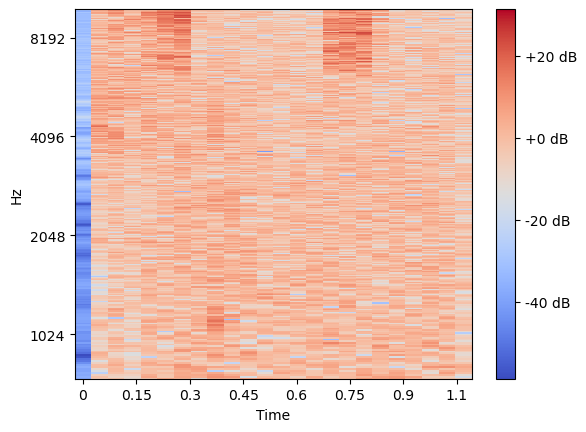

122280.wav


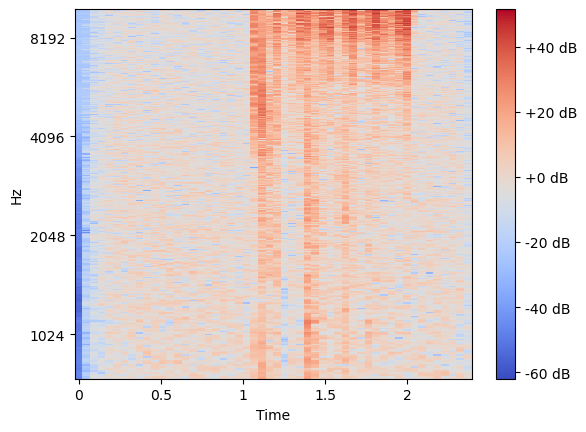

122267.wav


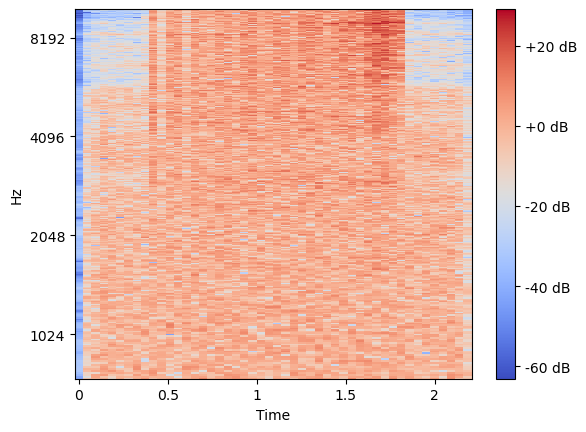

122264.wav


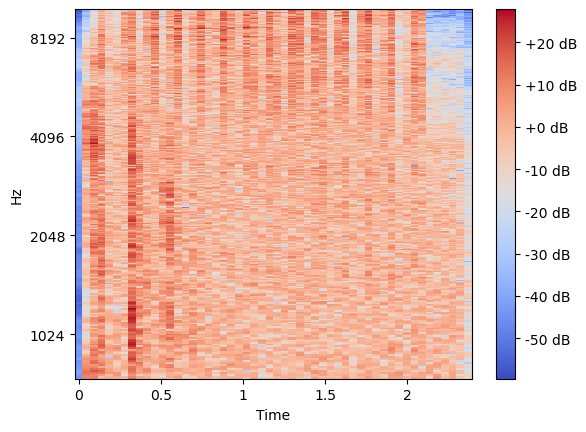

122270.wav


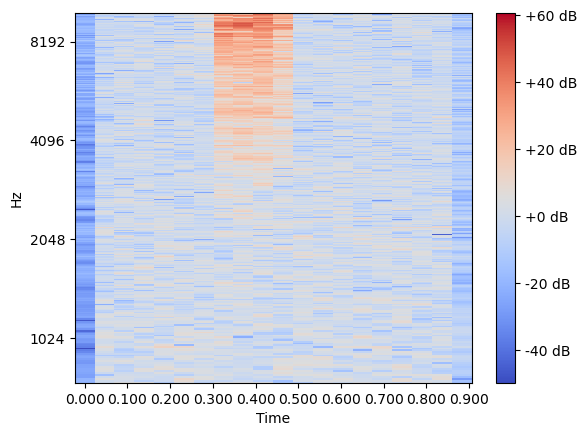

122338.wav


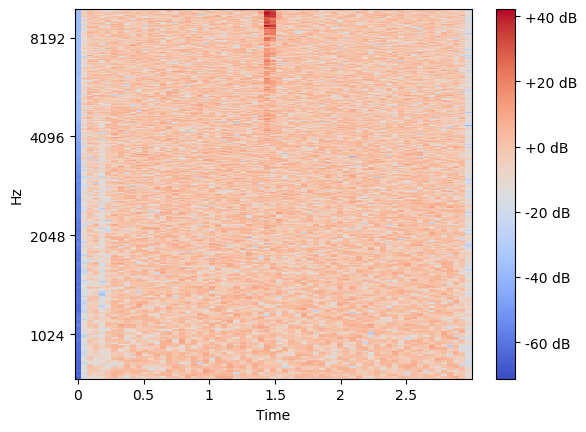

122339.wav


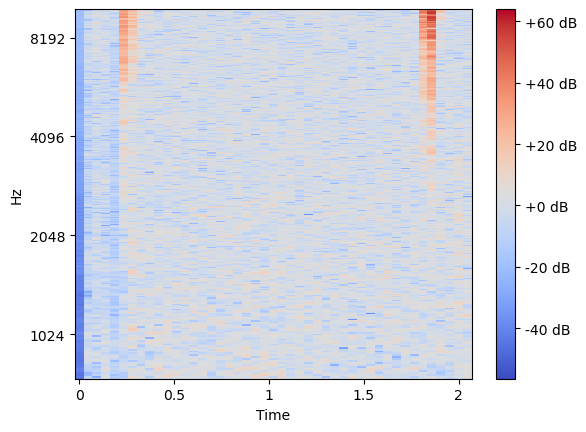

122275.wav


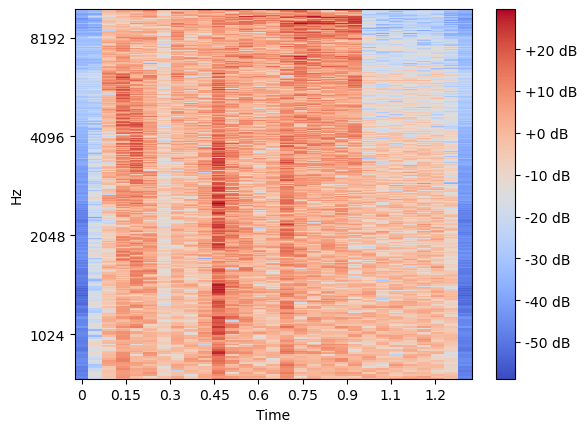

122249.wav


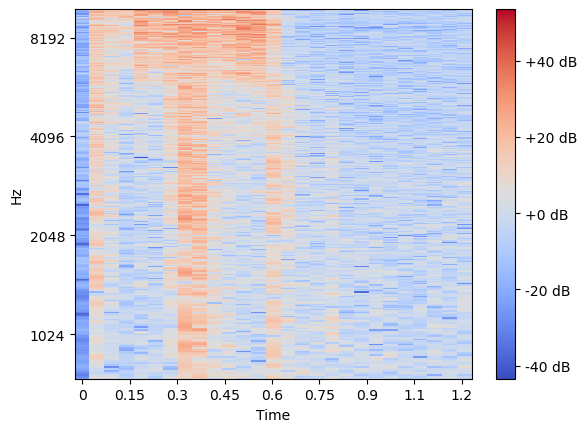

122248.wav


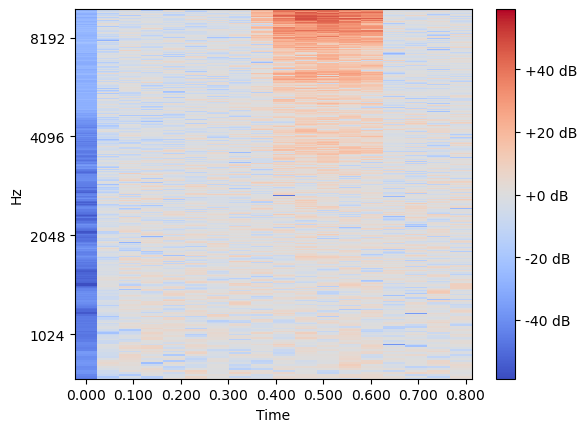

122263.wav


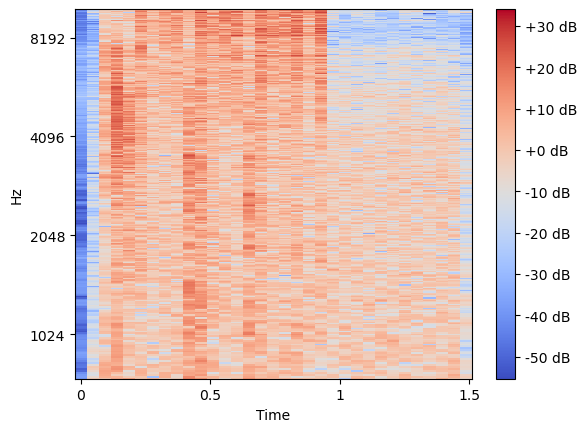

122239.wav


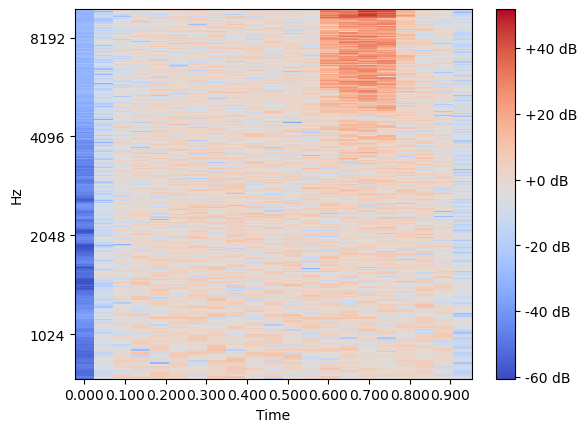

131535.wav


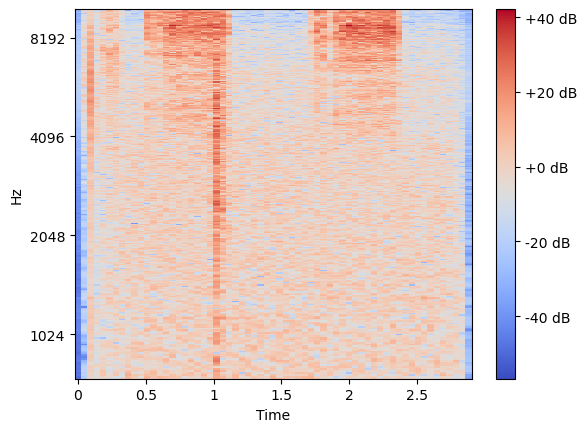

122206.wav


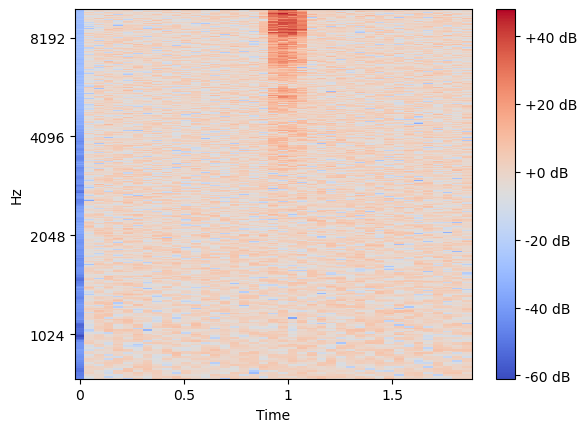

122377.wav


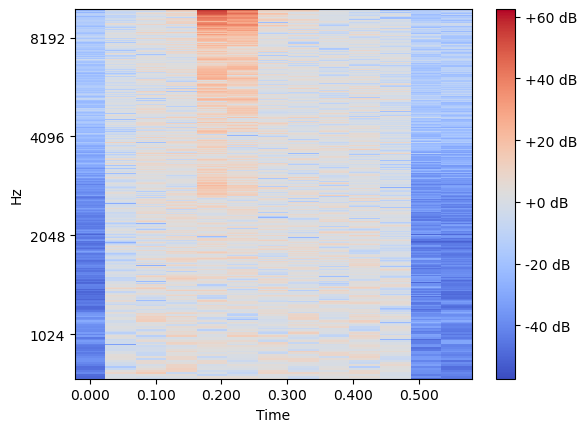

122375.wav


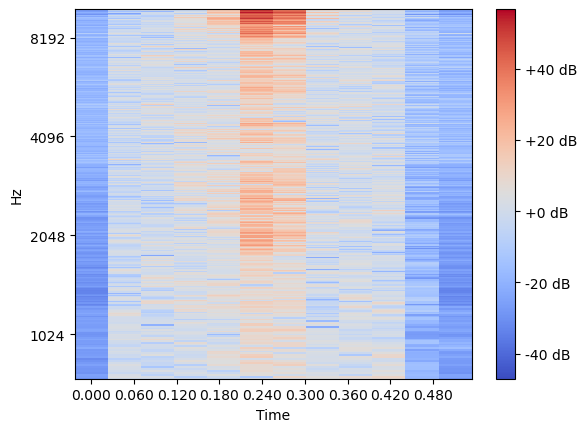

In [233]:
get_plot(directory, no_talk = True, remove_low = True, cleaned = True, print_filename = True)

122219.wav


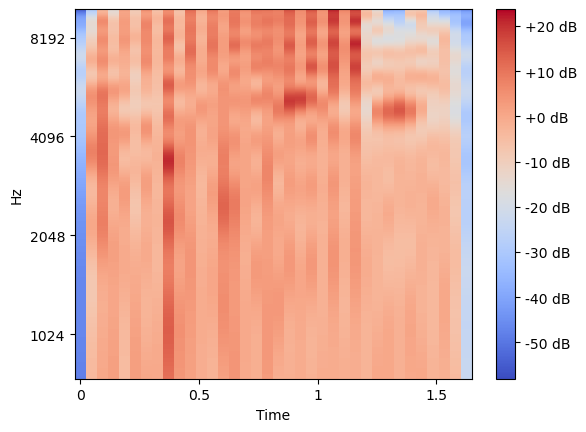

119884.wav


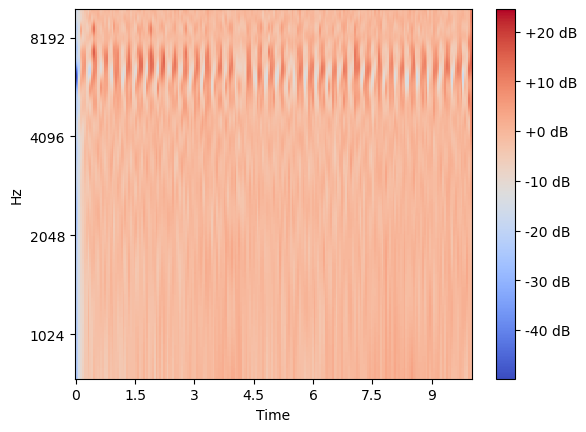

122147.wav


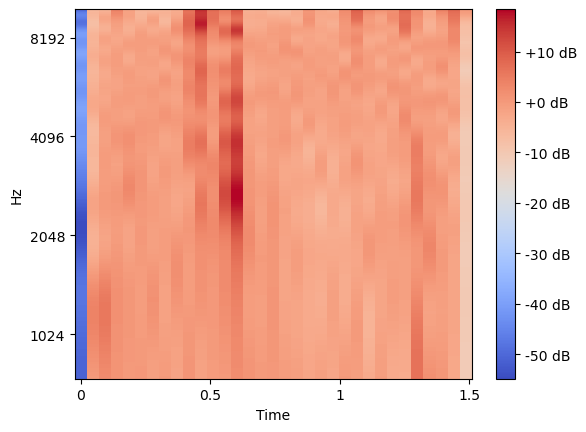

122218.wav


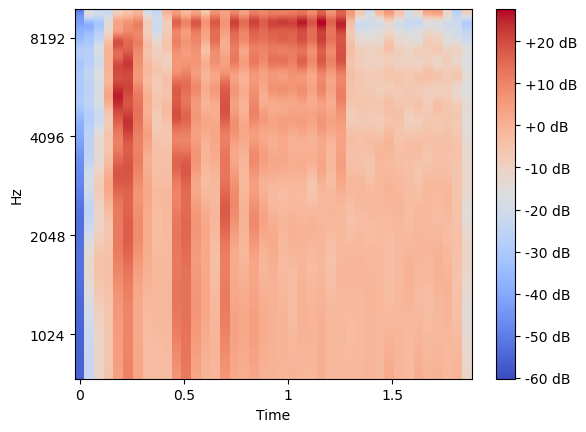

118960_mole.wav


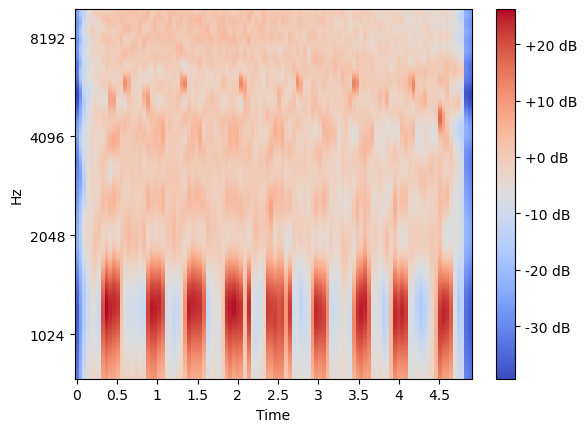

122140.wav


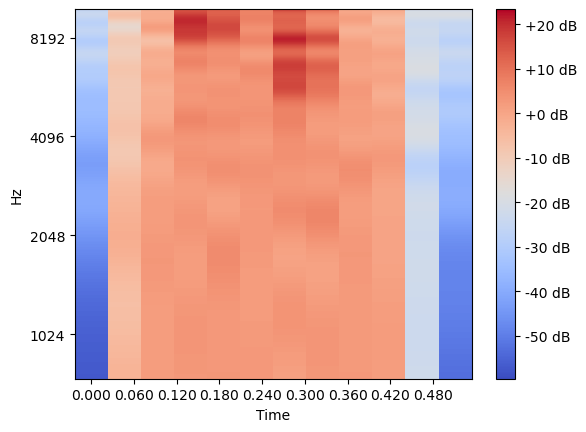

122340.wav


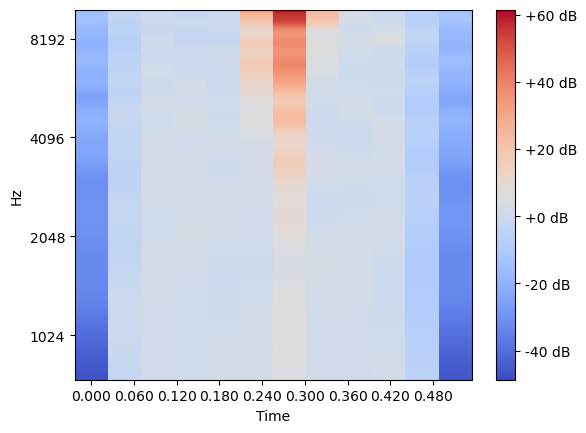

126899.wav


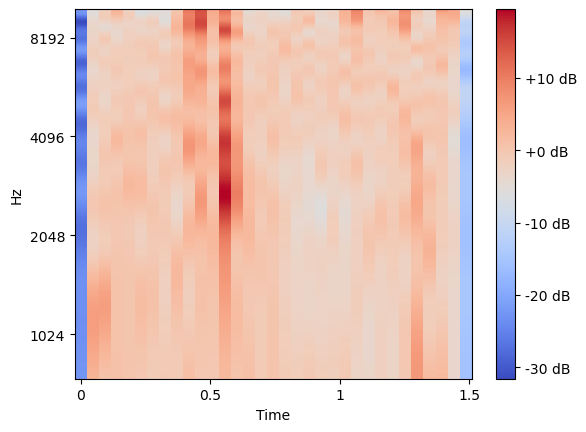

122221.wav


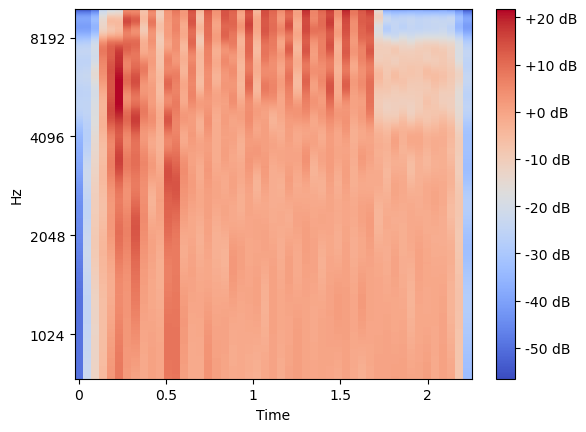

122246.wav


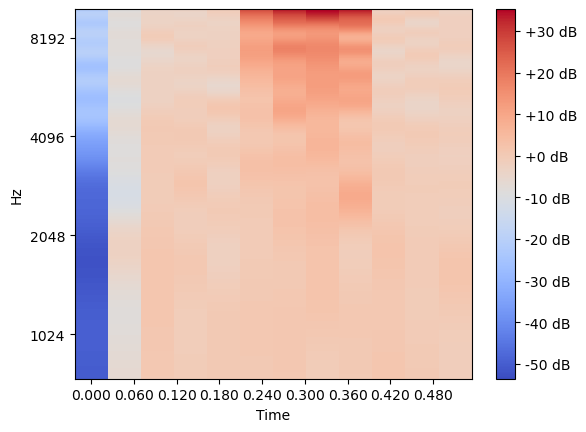

122247.wav


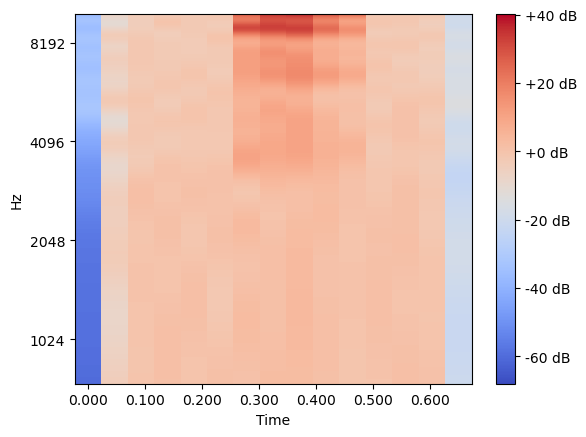

122245.wav


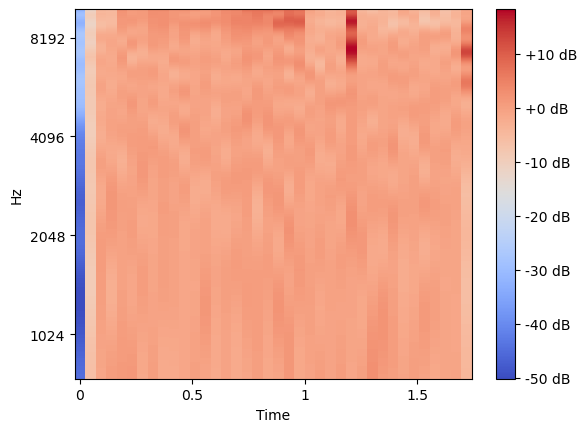

122278.wav


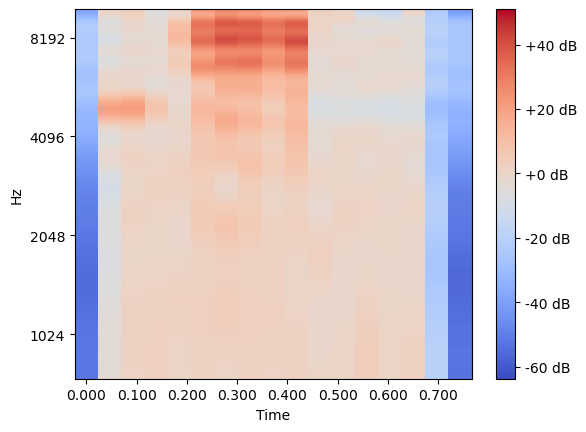

122283.wav


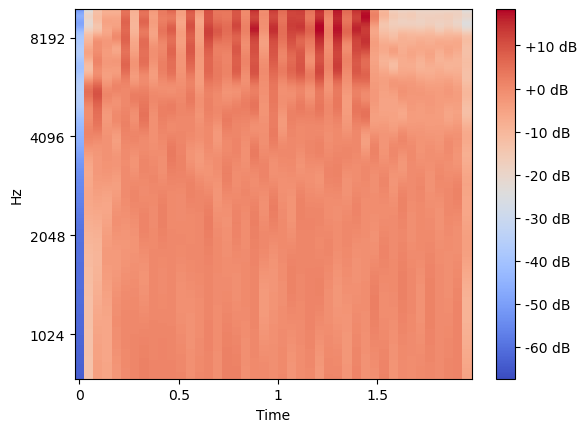

122269.wav


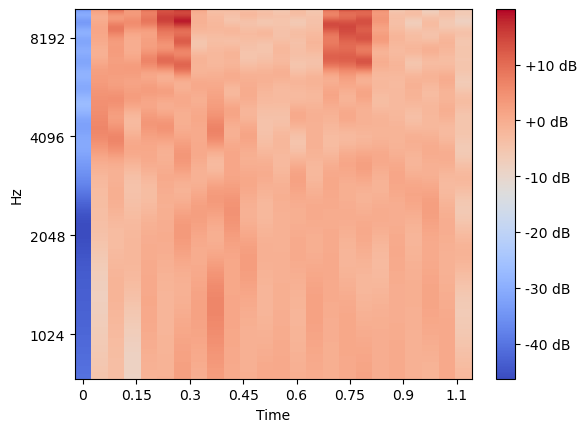

122280.wav


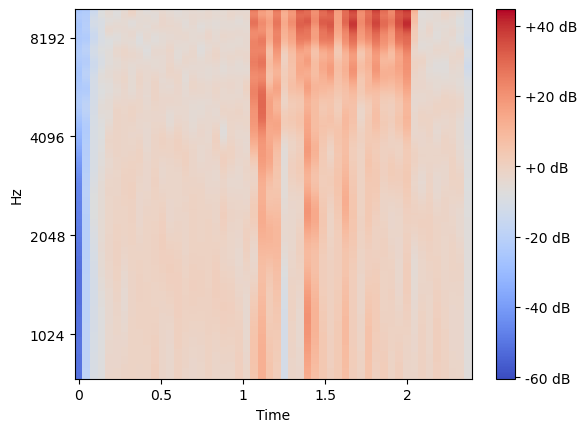

122267.wav


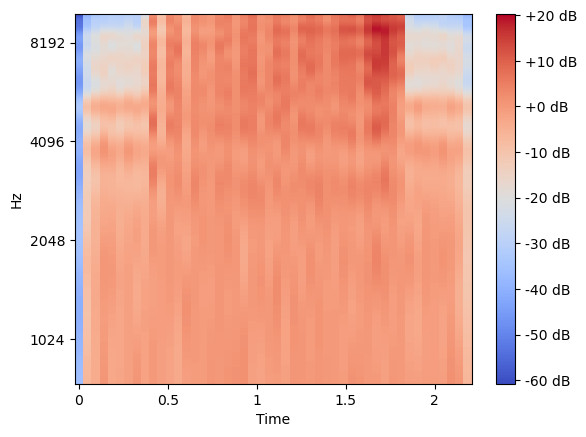

122264.wav


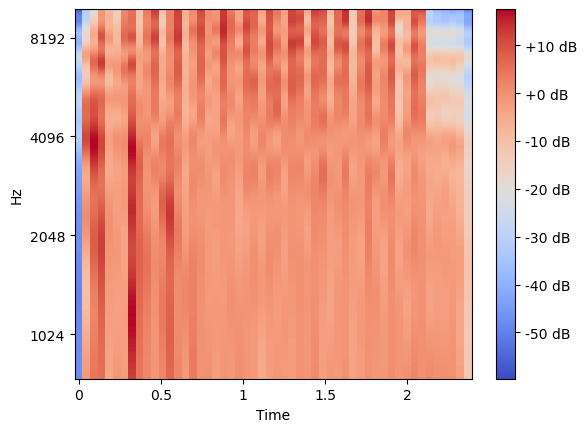

122270.wav


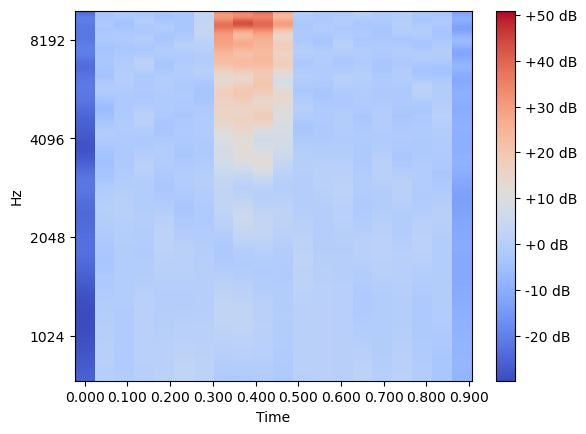

122338.wav


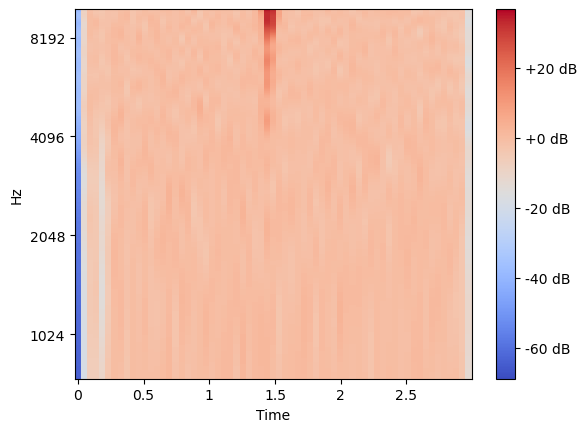

122339.wav


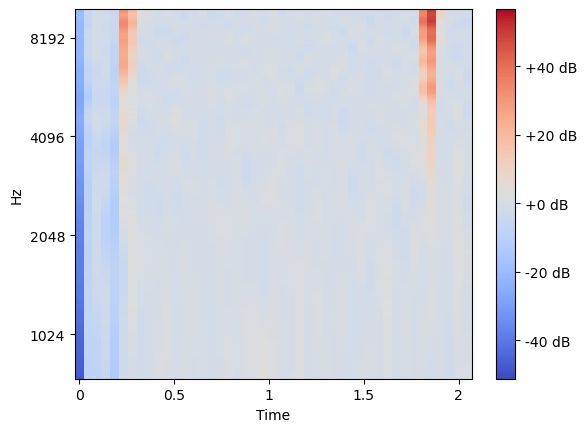

122275.wav


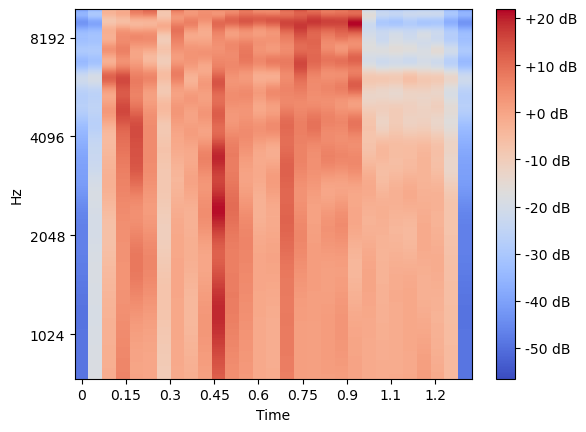

122249.wav


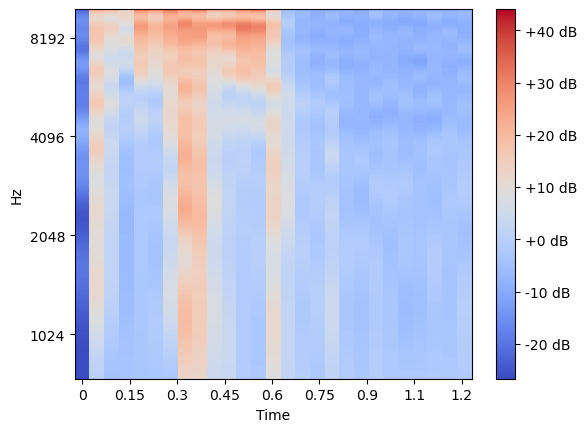

122248.wav


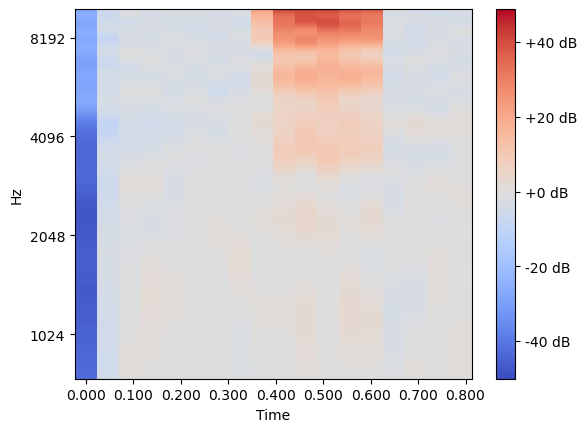

122263.wav


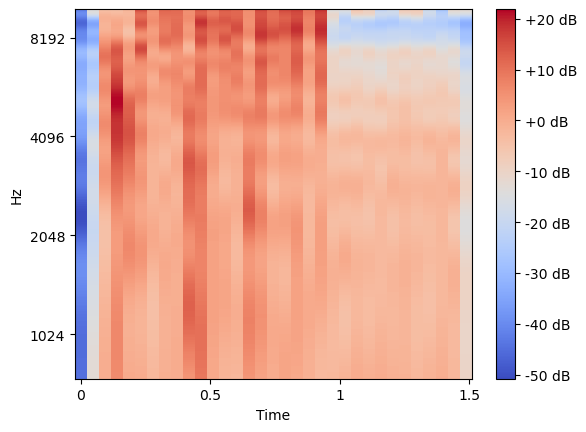

122239.wav


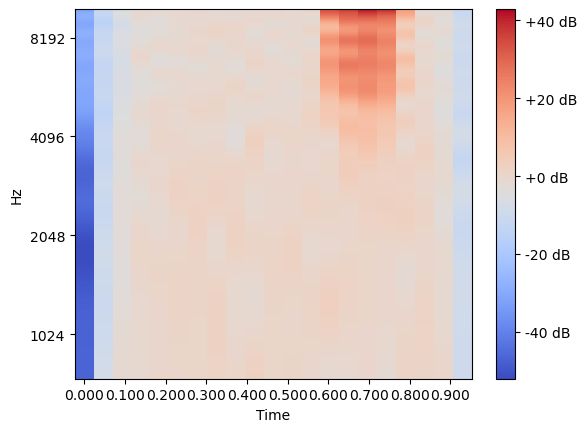

131535.wav


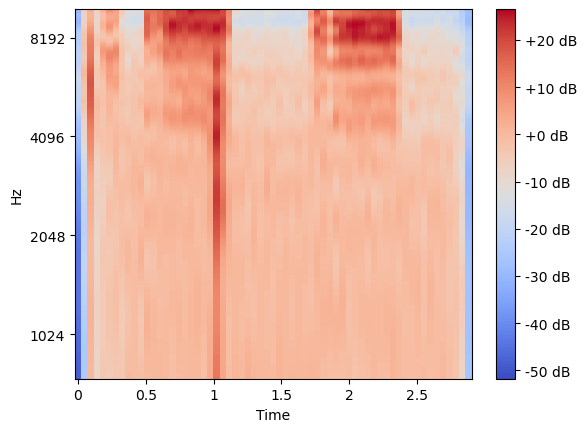

122206.wav


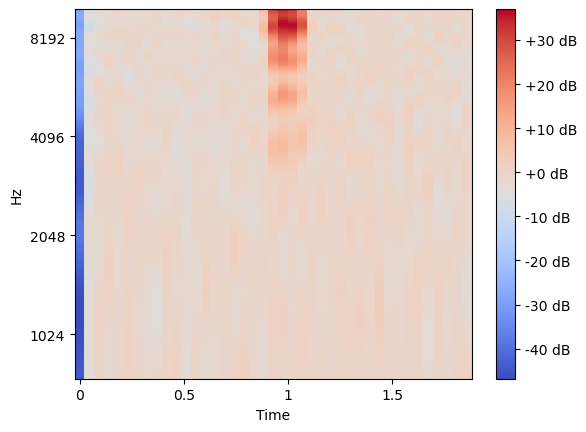

122377.wav


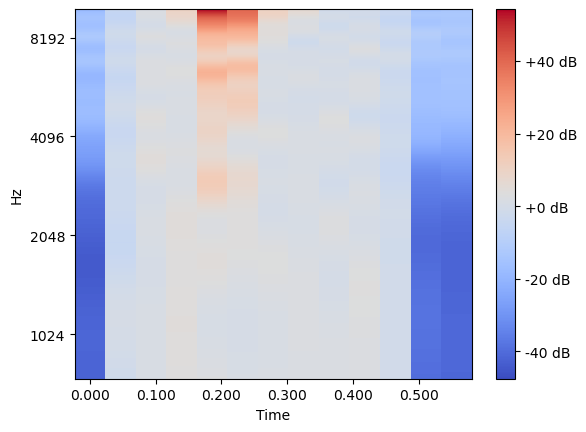

122375.wav


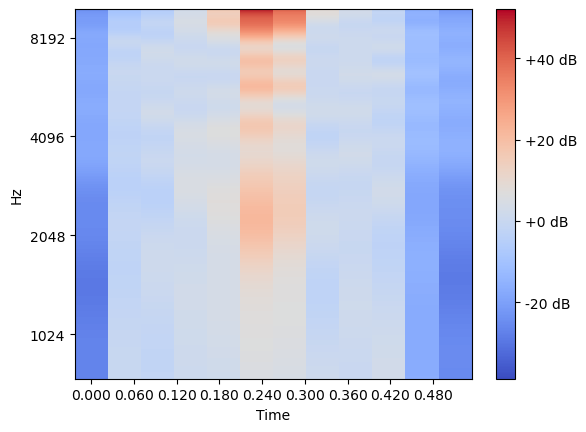

[]

In [248]:
get_dct(directory, n=20, cleaned = True, plot = 2, print_filename = True)

122219.wav


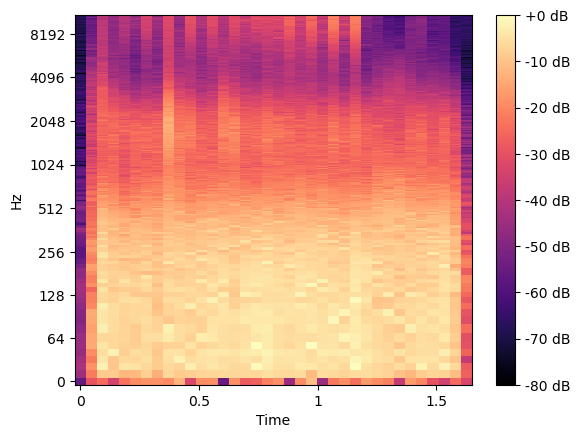

119884.wav


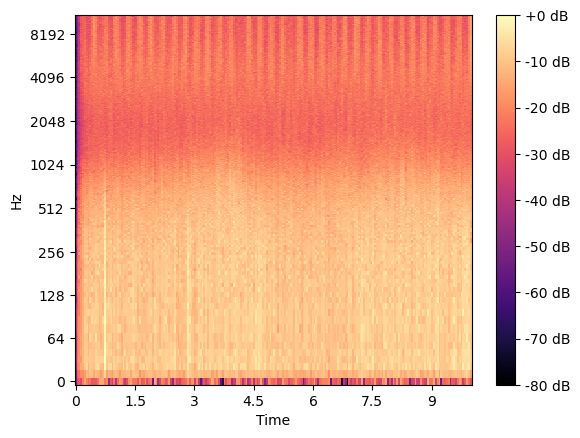

122147.wav


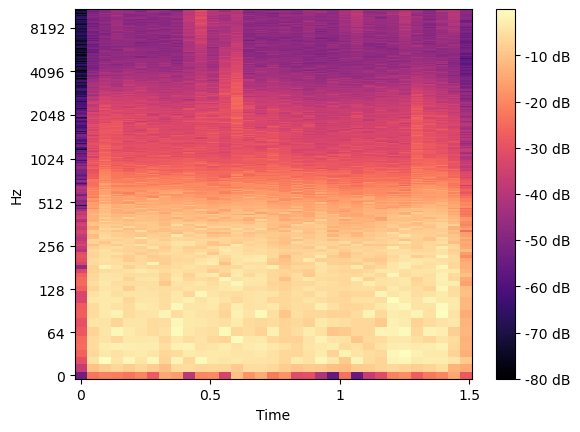

122218.wav


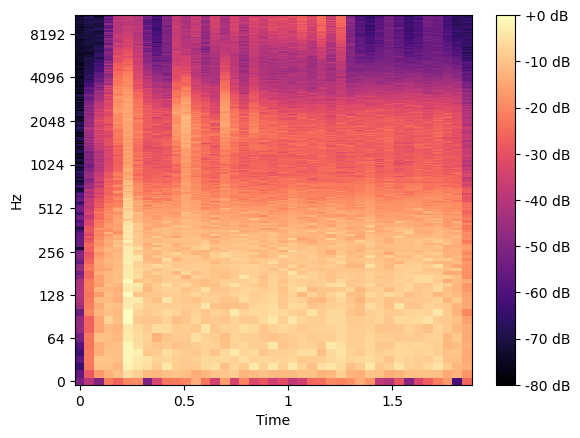

118960_mole.wav


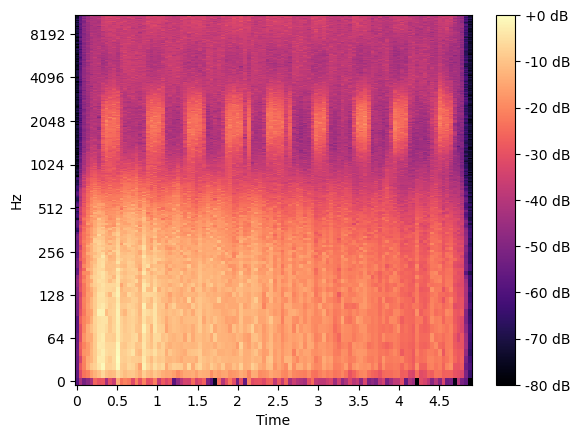

122140.wav


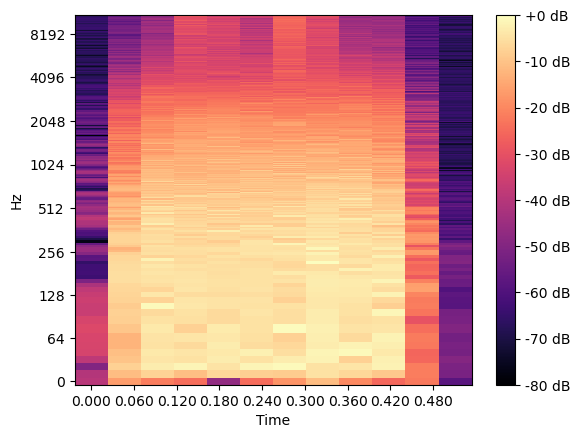

122340.wav


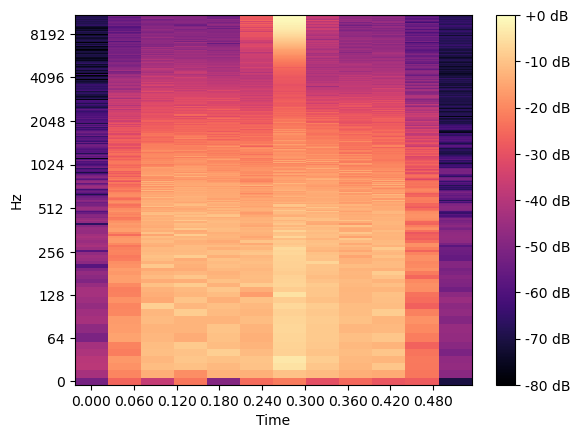

126899.wav


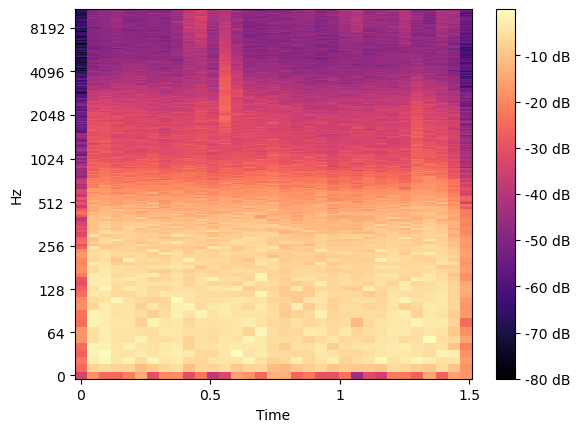

122221.wav


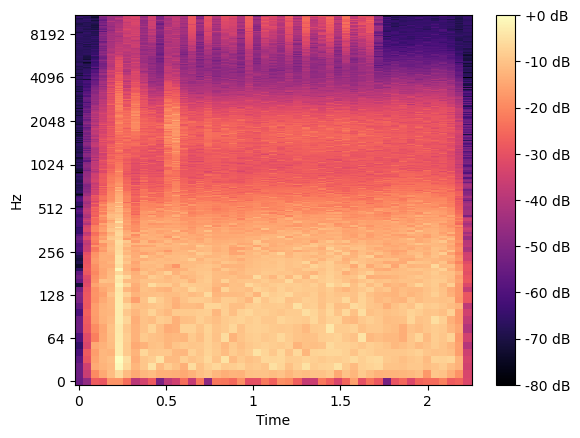

122246.wav


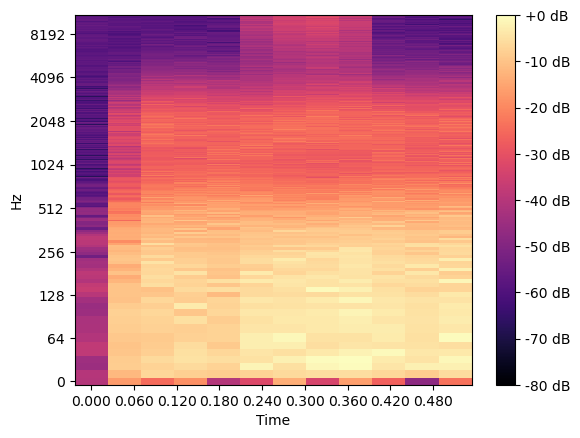

122247.wav


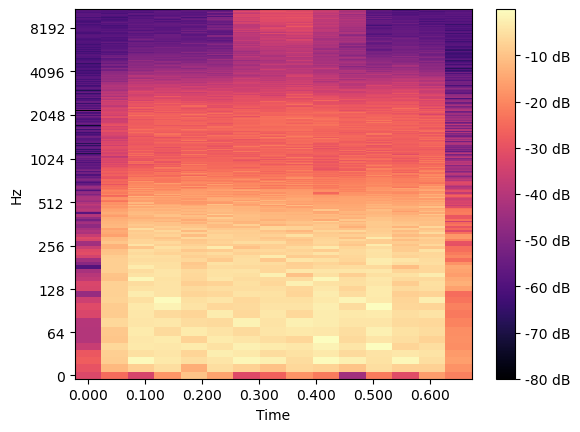

122245.wav


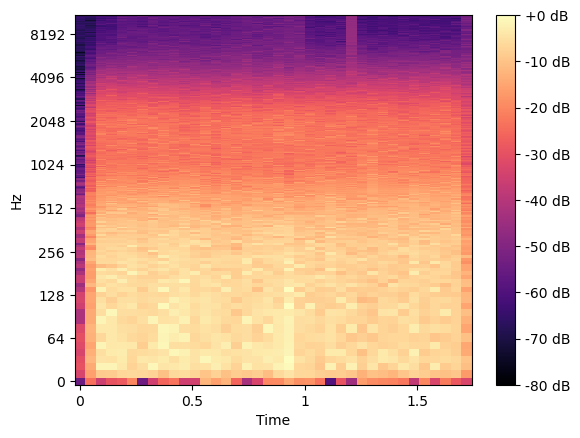

122278.wav


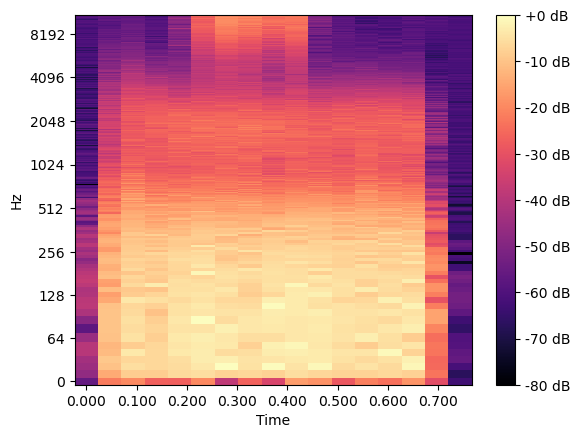

122283.wav


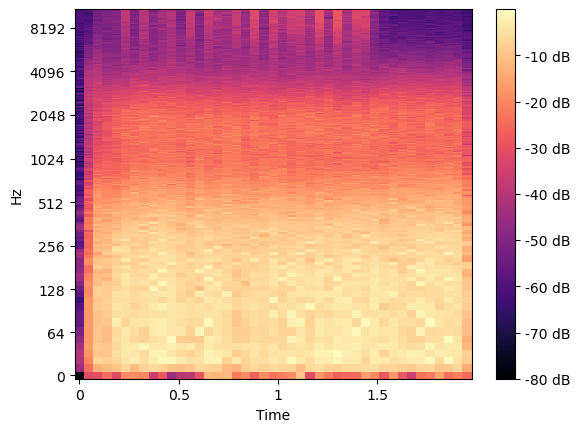

122269.wav


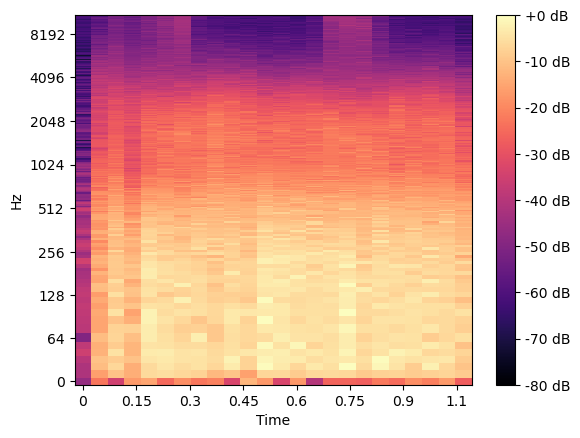

122280.wav


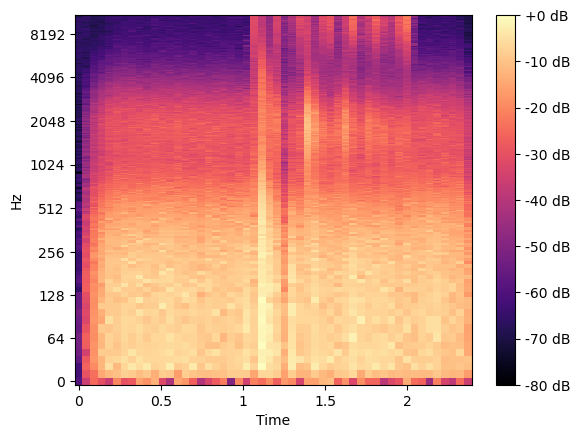

122267.wav


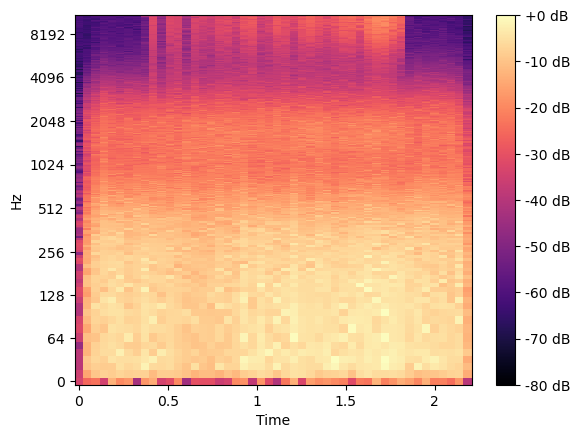

122264.wav


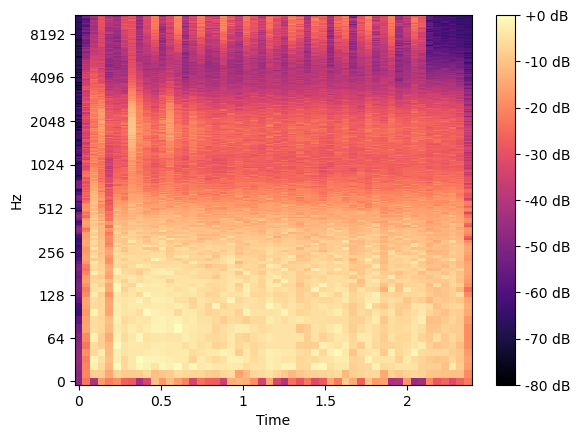

122270.wav


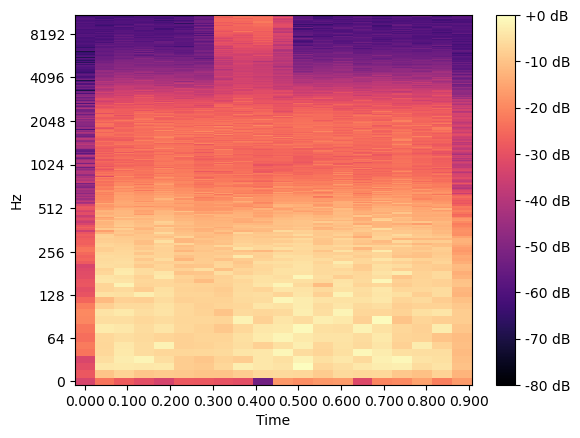

122338.wav


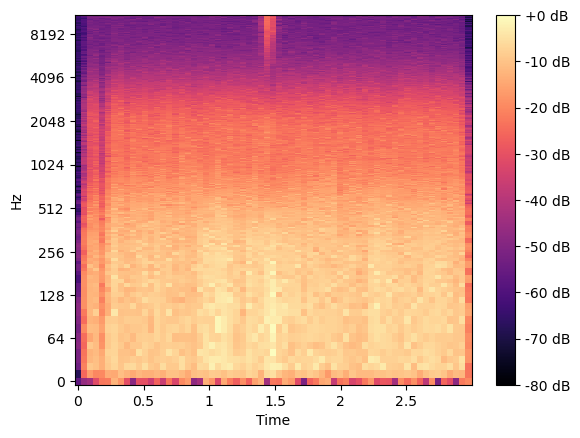

122339.wav


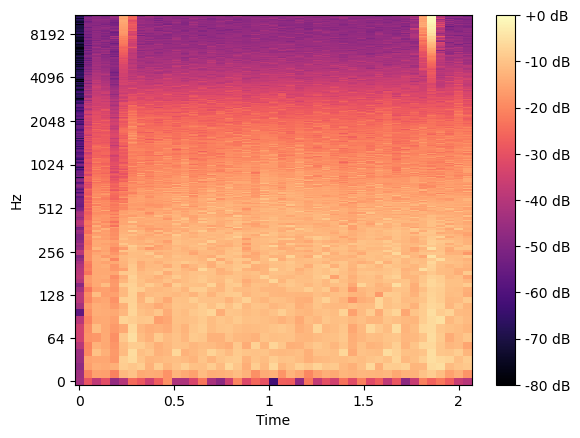

122275.wav


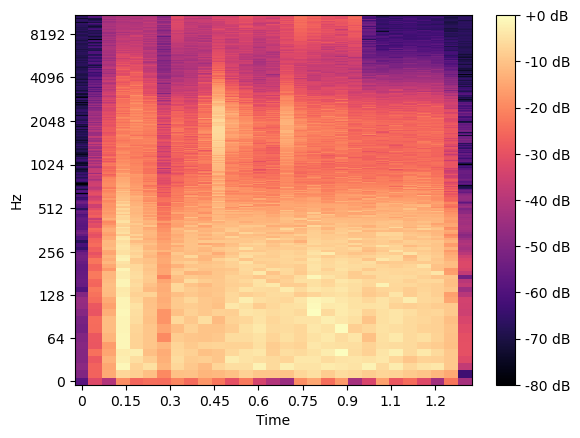

122249.wav


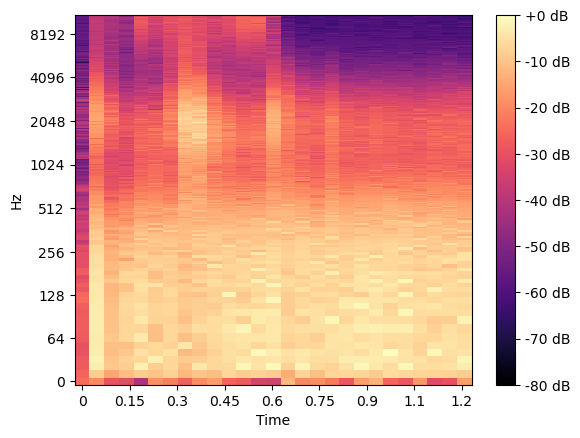

122248.wav


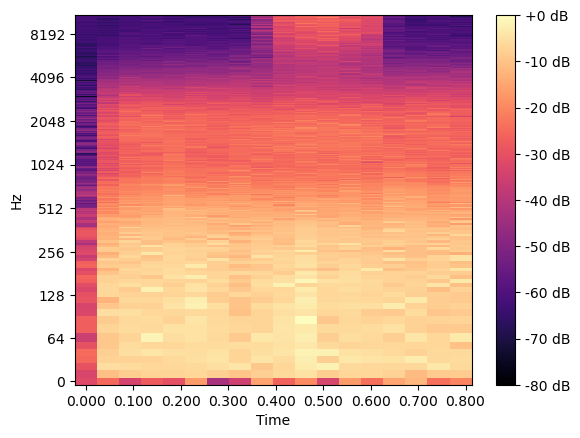

122263.wav


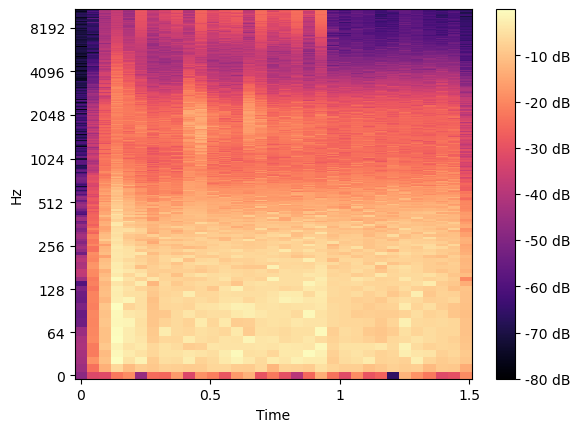

122239.wav


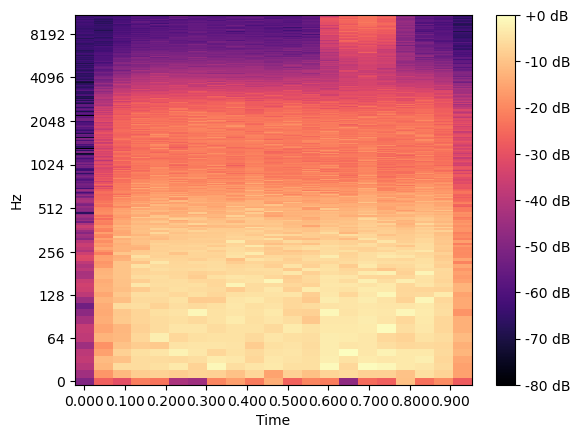

131535.wav


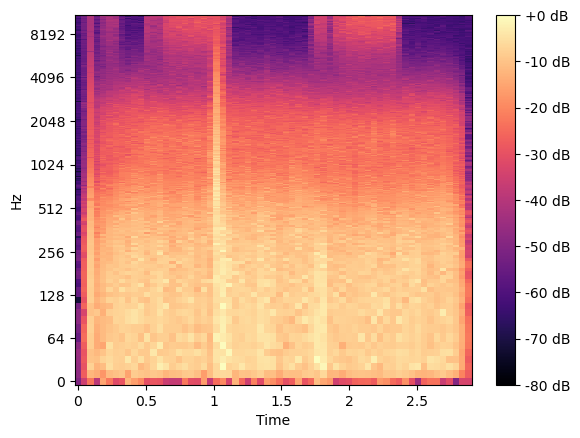

122206.wav


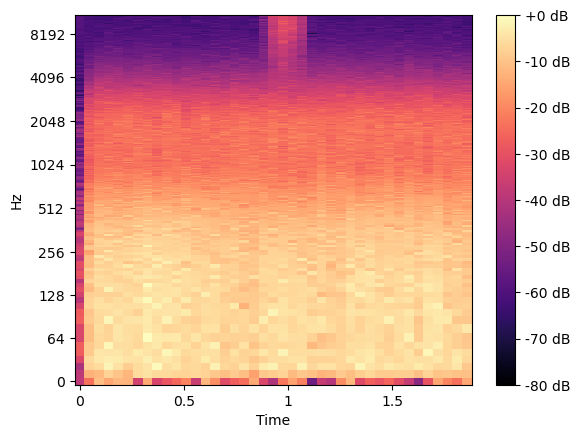

122377.wav


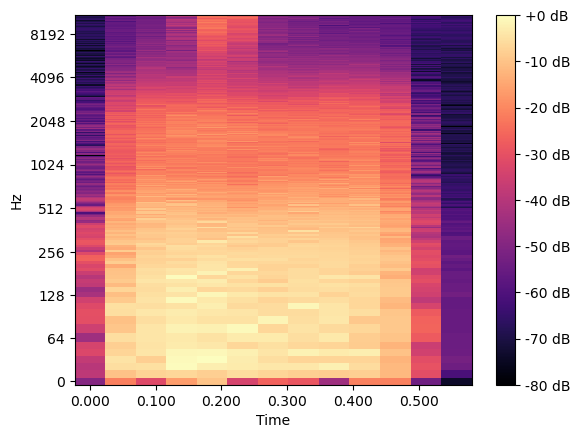

122375.wav


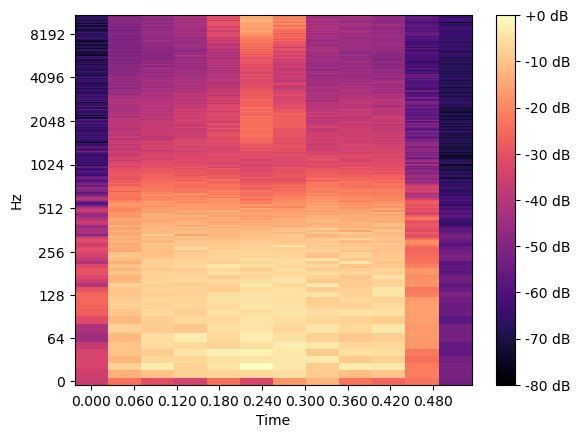

[]

In [232]:
get_mfcc(directory, n=5, plot = 2, print_filename=True)